# Rule-Based Baseline with Text Normalization

**Approach**: Exact and fuzzy string matching against lookup tables with text normalization

## Baseline Performance Target

From the EDA (Exploratory Data Analysis) we observed the class distribution in our evaluation dataset:
- **55% of departments are labeled as "Other"**
- **35% of seniority levels are "Professional"**

**Naive Baseline**: A model that always predicts "Other" for department would achieve 55% accuracy. A model that always predicts "Professional" for seniority would achieve 35% accuracy.

**Goal**: Every model in this project must beat these naive baseline accuracies.

## Model Configuration:
This notebook implements the optimized rule-based approach with:

1. **Text Normalization**: Lowercase conversion + whitespace cleaning
2. **Department Classification**: Can fall back to "Other" if no match found
3. **Seniority Classification**: Must always assign one of 6 levels, can fall back to "Professional"

## Module Optimizations (src/models/rule_based.py):
- ✅ Fuzzy matching implementation using `difflib.SequenceMatcher`
- ✅ Strategy reordering: Fast methods (Keyword) before slow methods (Fuzzy)
- ✅ Length-based pre-filtering to skip impossible matches

## Matching Strategies (in order):
1. Exact match (O(1) - instant)
2. Substring match (O(n) - fast)
3. Keyword match (O(n) - fast)
4. Fuzzy match (O(n*m) - last resort, optimized)
5. Default fallback (Department: "Other", Seniority: "Professional")

**Training Data**: Lookup tables (~19k examples)  
**Validation Data**: Annotated LinkedIn CVs (623 positions)

In [6]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import data loaders and models
import sys
sys.path.append('../')

from src.data.loader import load_label_lists, load_inference_dataset, load_evaluation_dataset
from src.models.rule_based import RuleConfig, create_department_classifier, create_seniority_classifier

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

%matplotlib inline

## 1. Load Training Data (Lookup Tables)

In [7]:
# Load lookup tables
dept_df, sen_df = load_label_lists(DATA_DIR)

print(f"Department lookup: {len(dept_df):,} examples")
print(f"Seniority lookup:  {len(sen_df):,} examples")
print(f"\nUnique departments: {dept_df['label'].nunique()}")
print(f"Unique seniority levels: {sen_df['label'].nunique()}")

Applying encoding fix...
Deduplicating department labels...
  Deduplication: 10145 -> 10145 (removed 0 duplicates)
  Capping: 10145 -> 2597 (max 500 per class)
Deduplicating seniority labels...
  Deduplication: 9428 -> 9428 (removed 0 duplicates)
  Capping: 9428 -> 2409 (max 500 per class)
Department lookup: 2,597 examples
Seniority lookup:  2,409 examples

Unique departments: 11
Unique seniority levels: 5


In [8]:
from sklearn.model_selection import train_test_split

# Note: Rule-based models do not "train" on the lookup tables.
# The lookup tables are treated as fixed rule/label dictionaries.
# We only use train_test_split later to create a fair dev/test split
# on the annotated SnapAddy evaluation dataset (to avoid tuning on the test set).

## 2. Build Rule-Based Classifiers

In [9]:
from src.models.rule_based import RuleConfig, create_department_classifier, create_seniority_classifier

# Configure WITH text normalization (best performance)
# IMPORTANT: Department can have "Other", but Seniority must choose from 6 levels
config_dept = RuleConfig(
    fuzzy_threshold=0.8, 
    use_text_normalization=True,  # Enable normalization for best results
    default_label="Other"  # Department can fall back to "Other"
)

config_sen = RuleConfig(
    fuzzy_threshold=0.8, 
    use_text_normalization=True,  # Enable normalization for best results
    default_label="Professional"  # Seniority must choose one of the 6 levels (most common fallback)
)

# Create classifiers WITH text normalization AND keyword matching
# Using factory functions to automatically include predefined keywords
dept_clf = create_department_classifier(dept_df, config=config_dept)
sen_clf = create_seniority_classifier(sen_df, config=config_sen)

print("✅ Department classifier created (WITH text normalization + keywords)")
print(f"   Text normalization: ✅ ENABLED (lowercase + whitespace)")
print(f"   Keyword matching: ✅ ENABLED (predefined department keywords)")
print(f"   Default fallback: 'Other' (department can be unspecified)")
print("✅ Seniority classifier created (WITH text normalization + keywords)")
print(f"   Text normalization: ✅ ENABLED (lowercase + whitespace)")
print(f"   Keyword matching: ✅ ENABLED (predefined seniority keywords)")
print(f"   Default fallback: 'Professional' (must choose from 6 levels)")
print(f"\nConfiguration:")
print(f"  Fuzzy match threshold: {config_dept.fuzzy_threshold} (80% similarity required)")
print(f"\nAvailable Seniority Levels: Director, Junior, Lead, Management, Professional, Senior")
print(f"Note: Seniority has NO 'Other' category - must always assign one of the 6 levels!")

✅ Department classifier created (WITH text normalization + keywords)
   Text normalization: ✅ ENABLED (lowercase + whitespace)
   Keyword matching: ✅ ENABLED (predefined department keywords)
   Default fallback: 'Other' (department can be unspecified)
✅ Seniority classifier created (WITH text normalization + keywords)
   Text normalization: ✅ ENABLED (lowercase + whitespace)
   Keyword matching: ✅ ENABLED (predefined seniority keywords)
   Default fallback: 'Professional' (must choose from 6 levels)

Configuration:
  Fuzzy match threshold: 0.8 (80% similarity required)

Available Seniority Levels: Director, Junior, Lead, Management, Professional, Senior
Note: Seniority has NO 'Other' category - must always assign one of the 6 levels!


## Demonstration: Text Normalization Effect

Let's see how text normalization works:

In [10]:
# Example: How text normalization works
from src.models.rule_based import HybridRuleClassifier

# Create a dummy classifier to use the normalization function
dummy_df = pd.DataFrame({'text': ['dummy'], 'label': ['dummy']})
dummy_clf = HybridRuleClassifier(dummy_df)

# Test cases showing normalization effects
test_cases = [
    "Senior  Software   Engineer",      # Multiple spaces
    "Senior Software Engineer",         # Normal
    " Senior Software Engineer ",       # Leading/trailing spaces
    "SENIOR SOFTWARE ENGINEER",         # Uppercase
    "Senior\tSoftware\nEngineer",       # Tabs & newlines
    "  TEAM  LEADER   IT  ",            # Mixed issues
]

print("Text Normalization Examples:")
print("=" * 80)
print(f"{'Original':<40} → {'Normalized':<40}")
print("-" * 80)

for text in test_cases:
    normalized = dummy_clf._clean_text(text)
    # Show whitespace issues visually
    original_display = repr(text)[:38]
    print(f"{original_display:<40} → {normalized:<40}")

print("\n✅ All variations are now normalized to the same format!")
print("This helps matching: 'Senior  Engineer' will now match 'Senior Engineer' in lookup table")

Text Normalization Examples:
Original                                 → Normalized                              
--------------------------------------------------------------------------------
'Senior  Software   Engineer'            → senior software engineer                
'Senior Software Engineer'               → senior software engineer                
' Senior Software Engineer '             → senior software engineer                
'SENIOR SOFTWARE ENGINEER'               → senior software engineer                
'Senior\tSoftware\nEngineer'             → senior software engineer                
'  TEAM  LEADER   IT  '                  → team leader it                          

✅ All variations are now normalized to the same format!
This helps matching: 'Senior  Engineer' will now match 'Senior Engineer' in lookup table


## 3. Inference Demo on Unannotated CVs

In [11]:
# Load unannotated CVs for demonstration
inference_df = load_inference_dataset(DATA_DIR)

print(f"Loaded {len(inference_df):,} unannotated CV positions for inference demo")
print(f"\nFirst few job titles:")
for i, row in inference_df.head(10).iterrows():
    print(f"  {i+1}. {row['title']}")

Loaded 314 unannotated CV positions for inference demo

First few job titles:
  1. Bookkeeper
  2. Strategy & Investments
  3. Corporate Auditor
  4. Marketing Manager
  5. Professor
  6. Program Purchasing Leader / Program / Acquisition Buyer
  7. Business Analyst
  8. Managementberater IT- und Governance
  9. Founder & CEO
  10. Geschäftsführer


In [12]:
# Make predictions on sample
sample_titles = inference_df['title'].head(20).tolist()

# Predict with details (includes match method and confidence)
dept_preds = dept_clf.predict_with_details(sample_titles)
sen_preds = sen_clf.predict_with_details(sample_titles)

# Display results
print("\n" + "="*100)
print("INFERENCE DEMO: Rule-Based Predictions")
print("="*100)
print(f"{'Title':<40} | {'Department':<20} | {'Seniority':<15} | {'Methods':<20}")
print("-"*100)

for title, (dept, dept_conf, dept_method), (sen, sen_conf, sen_method) in zip(sample_titles, dept_preds, sen_preds):
    title_short = title[:37] + "..." if len(title) > 40 else title
    methods = f"{dept_method[:4]}/{sen_method[:4]}"
    print(f"{title_short:<40} | {dept:<20} | {sen:<15} | {methods:<20}")


INFERENCE DEMO: Rule-Based Predictions
Title                                    | Department           | Seniority       | Methods             
----------------------------------------------------------------------------------------------------
Bookkeeper                               | Other                | Professional    | defa/defa           
Strategy & Investments                   | Other                | Professional    | defa/defa           
Corporate Auditor                        | Other                | Professional    | defa/defa           
Marketing Manager                        | Marketing            | Senior          | keyw/exac           
Professor                                | Other                | Professional    | defa/defa           
Program Purchasing Leader / Program /... | Purchasing           | Lead            | keyw/keyw           
Business Analyst                         | Business Development | Junior          | fuzz/exac           
Managementberater I

## 4. Match Method Statistics

Let's analyze which matching strategies are being used most often.

In [13]:
# Analyze matching methods on inference data
all_titles = inference_df['title'].tolist()
dept_stats = dept_clf.get_stats(all_titles)
sen_stats = sen_clf.get_stats(all_titles)

print("Department Classification Methods:")
for method, count in dept_stats.items():
    pct = 100 * count / len(all_titles)
    print(f"  {method:<15}: {count:>5} ({pct:>5.1f}%)")

print("\nSeniority Classification Methods:")
for method, count in sen_stats.items():
    pct = 100 * count / len(all_titles)
    print(f"  {method:<15}: {count:>5} ({pct:>5.1f}%)")

Department Classification Methods:
  exact          :    13 (  4.1%)
  substring      :    16 (  5.1%)
  keyword        :    85 ( 27.1%)
  default        :   180 ( 57.3%)

Seniority Classification Methods:
  exact          :    32 ( 10.2%)
  substring      :    66 ( 21.0%)
  keyword        :   145 ( 46.2%)
  default        :    68 ( 21.7%)


## 5. Evaluation on Annotated Dataset

⚠️ **FIRST TIME LOADING ANNOTATED DATA**

Now we evaluate on the held-out annotated dataset to get true performance metrics.

In [14]:
# Load annotated dataset for evaluation
eval_df = load_evaluation_dataset(DATA_DIR)

print(f"📊 Loaded {len(eval_df)} annotated CV positions for evaluation")
print(f"\nColumns: {list(eval_df.columns)}")
print(f"\nChecking for missing labels:")
print(f"  Missing department labels: {eval_df['department'].isna().sum()}")
print(f"  Missing seniority labels: {eval_df['seniority'].isna().sum()}")

📊 Loaded 478 annotated CV positions for evaluation

Columns: ['cv_id', 'title', 'company', 'text', 'department', 'seniority']

Checking for missing labels:
  Missing department labels: 0
  Missing seniority labels: 0


In [15]:
# Create a dev/test split on the annotated evaluation dataset
# (dev can be used for threshold/keyword tuning; test is held-out for reporting)
try:
    eval_dev_df, eval_test_df = train_test_split(
        eval_df,
        test_size=0.2,
        random_state=42,
        stratify=eval_df["department"]
    )
except ValueError:
    # Fallback if stratification is not possible due to very small classes
    eval_dev_df, eval_test_df = train_test_split(
        eval_df,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

print(f"Evaluation split: Dev={len(eval_dev_df):,}, Test={len(eval_test_df):,}")

Evaluation split: Dev=382, Test=96


### 5.1 Department Evaluation

In [16]:
# Predict on evaluation set
eval_titles = eval_test_df['title'].tolist()
dept_predictions = dept_clf.predict(eval_titles)

# Ground truth
dept_true = eval_test_df['department'].tolist()

# Calculate metrics
dept_accuracy = accuracy_score(dept_true, dept_predictions)
dept_precision, dept_recall, dept_f1, _ = precision_recall_fscore_support(
    dept_true, dept_predictions, average='macro', zero_division=0
)
dept_weighted_f1 = precision_recall_fscore_support(
    dept_true, dept_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("DEPARTMENT CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {dept_accuracy:.4f}")
print(f"Precision (macro): {dept_precision:.4f}")
print(f"Recall (macro):    {dept_recall:.4f}")
print(f"F1-score (macro):  {dept_f1:.4f}")
print(f"F1-score (wtd):    {dept_weighted_f1:.4f}")
print("="*60)


DEPARTMENT CLASSIFICATION RESULTS
Accuracy:          0.7708
Precision (macro): 0.6857
Recall (macro):    0.5205
F1-score (macro):  0.5718
F1-score (wtd):    0.7548


In [17]:
# Per-class F1 scores
dept_report = classification_report(dept_true, dept_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Department):")
dept_f1_scores = {label: metrics['f1-score'] for label, metrics in dept_report.items() 
                  if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(dept_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Department):
  Information Technology        : 0.8333
  Other                         : 0.8182
  Business Development          : 0.8000
  Consulting                    : 0.8000
  Sales                         : 0.8000
  Project Management            : 0.6667
  Marketing                     : 0.5714
  Human Resources               : 0.5000
  Purchasing                    : 0.5000
  Administrative                : 0.0000
  Customer Support              : 0.0000


### 5.2 Seniority Evaluation

In [18]:
# Predict on evaluation set
sen_predictions = sen_clf.predict(eval_titles)

# Ground truth
sen_true = eval_test_df['seniority'].tolist()

# Calculate metrics
sen_accuracy = accuracy_score(sen_true, sen_predictions)
sen_precision, sen_recall, sen_f1, _ = precision_recall_fscore_support(
    sen_true, sen_predictions, average='macro', zero_division=0
)
sen_weighted_f1 = precision_recall_fscore_support(
    sen_true, sen_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("SENIORITY CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {sen_accuracy:.4f}")
print(f"Precision (macro): {sen_precision:.4f}")
print(f"Recall (macro):    {sen_recall:.4f}")
print(f"F1-score (macro):  {sen_f1:.4f}")
print(f"F1-score (wtd):    {sen_weighted_f1:.4f}")
print("="*60)


SENIORITY CLASSIFICATION RESULTS
Accuracy:          0.5417
Precision (macro): 0.5010
Recall (macro):    0.5488
F1-score (macro):  0.4737
F1-score (wtd):    0.5843


In [19]:
# Per-class F1 scores
sen_report = classification_report(sen_true, sen_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Seniority):")
sen_f1_scores = {label: metrics['f1-score'] for label, metrics in sen_report.items() 
                 if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(sen_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Seniority):
  Management                    : 0.7636
  Junior                        : 0.5714
  Professional                  : 0.5600
  Lead                          : 0.5366
  Senior                        : 0.2105
  Director                      : 0.2000


## 6. Confusion Matrices

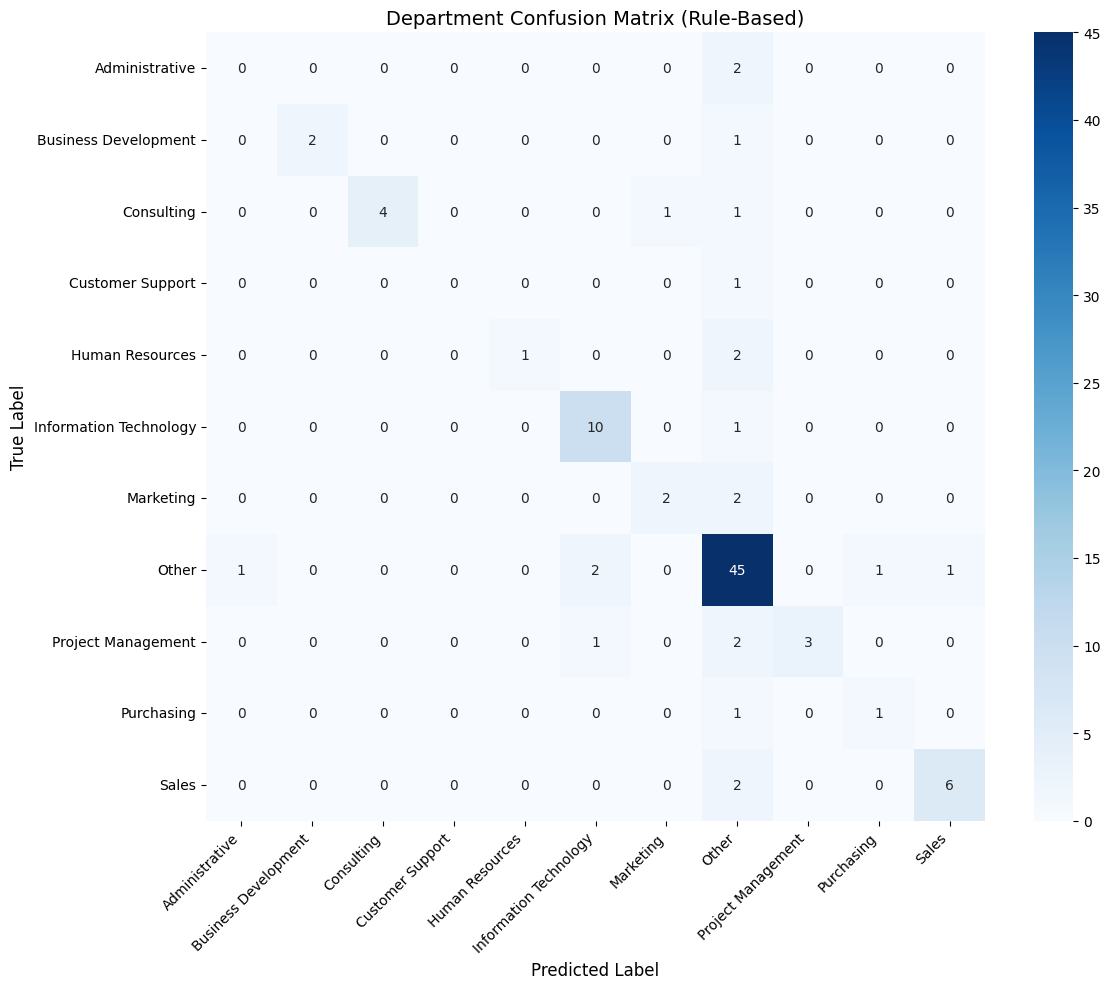

In [20]:
# Department confusion matrix
dept_cm = confusion_matrix(dept_true, dept_predictions)
dept_labels = sorted(set(dept_true + dept_predictions))

plt.figure(figsize=(12, 10))
sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels)
plt.title('Department Confusion Matrix (Rule-Based)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

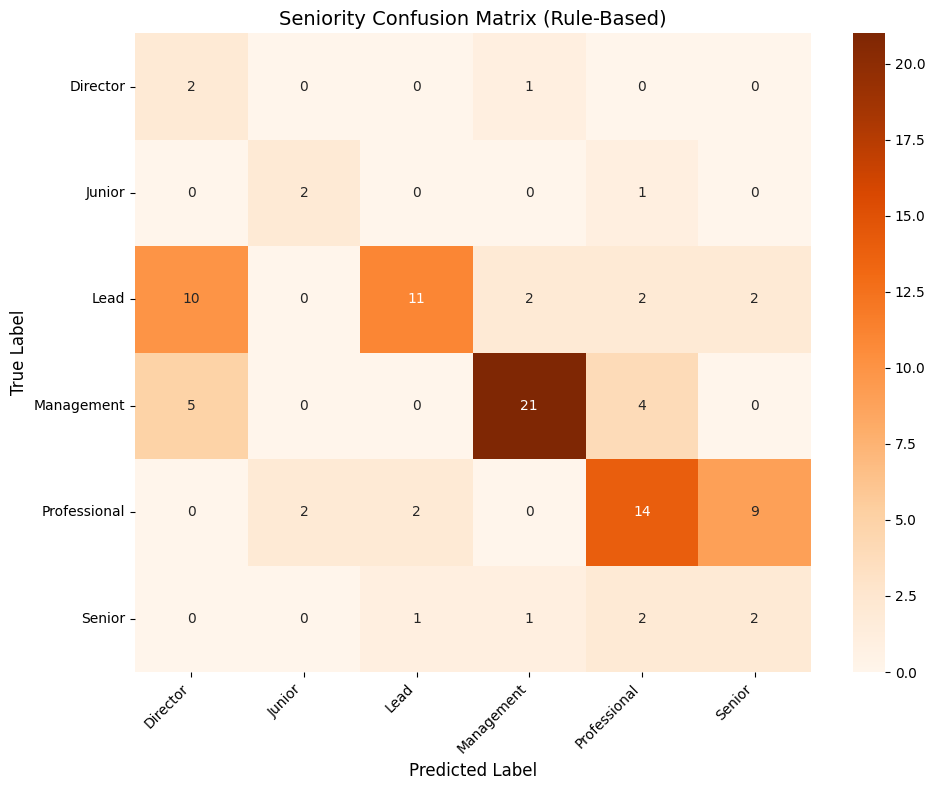

In [21]:
# Seniority confusion matrix
sen_cm = confusion_matrix(sen_true, sen_predictions)
sen_labels = sorted(set(sen_true + sen_predictions))

plt.figure(figsize=(10, 8))
sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels)
plt.title('Seniority Confusion Matrix (Rule-Based)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Error Analysis

In [22]:
# Find misclassified examples (on the held-out TEST split)
eval_results_df = eval_test_df.copy()

eval_results_df['dept_pred'] = dept_predictions
eval_results_df['sen_pred'] = sen_predictions
eval_results_df['dept_correct'] = eval_results_df['department'] == eval_results_df['dept_pred']
eval_results_df['sen_correct'] = eval_results_df['seniority'] == eval_results_df['sen_pred']

# Department errors
dept_errors = eval_results_df[~eval_results_df['dept_correct']]
print(f"\nDepartment errors (TEST): {len(dept_errors)} / {len(eval_results_df)} ({100*len(dept_errors)/len(eval_results_df):.1f}%)")
print("\nExample misclassifications (Department):")
for i, row in dept_errors.head(10).iterrows():
    print(f"  Title: {row['title']}")
    print(f"  True:  {row['department']}  | Pred: {row['dept_pred']}")
    print("-"*50)

# Seniority errors
sen_errors = eval_results_df[~eval_results_df['sen_correct']]
print(f"\nSeniority errors (TEST): {len(sen_errors)} / {len(eval_results_df)} ({100*len(sen_errors)/len(eval_results_df):.1f}%)")
print("\nExample misclassifications (Seniority):")
for i, row in sen_errors.head(10).iterrows():
    print(f"  Title: {row['title']}")
    print(f"  True:  {row['seniority']}  | Pred: {row['sen_pred']}")
    print("-"*50)


Department errors (TEST): 22 / 96 (22.9%)

Example misclassifications (Department):
  Title: Bereichsleiter Central Service Center
  True:  Customer Support  | Pred: Other
--------------------------------------------------
  Title: Geschäftsführer, CMO
  True:  Marketing  | Pred: Other
--------------------------------------------------
  Title: Owner - CSO
  True:  Sales  | Pred: Other
--------------------------------------------------
  Title: Data Analyst (Sustainable & Fund Finance)
  True:  Other  | Pred: Information Technology
--------------------------------------------------
  Title: Head of CapEx Delivery Management and Planning Site Leverkusen
  True:  Project Management  | Pred: Other
--------------------------------------------------
  Title: Partner
  True:  Business Development  | Pred: Other
--------------------------------------------------
  Title: CEO Morgenpost & TAG 24 | Vertriebsleiter Sächsische Zeitung / Lesermark | CEO MVD Ökoflitzer
  True:  Other  | Pred: Sale

## 8. Save Results for Comparison

Save evaluation results to JSON for final model comparison.

In [23]:
# Prepare results dictionary
results = {
    "approach": "Rule-Based (Exact + Fuzzy Matching) WITH Text Normalization",
    "text_normalization": True,
    "improvements": ["Lowercase conversion", "Whitespace normalization"],
    "department": {
        "accuracy": float(dept_accuracy),
        "precision": float(dept_precision),
        "recall": float(dept_recall),
        "f1_macro": float(dept_f1),
        "f1_weighted": float(dept_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in dept_f1_scores.items()}
    },
    "seniority": {
        "accuracy": float(sen_accuracy),
        "precision": float(sen_precision),
        "recall": float(sen_recall),
        "f1_macro": float(sen_f1),
        "f1_weighted": float(sen_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in sen_f1_scores.items()}
    },
    "metadata": {
        "evaluation_split": {"dev_size": len(eval_dev_df), "test_size": len(eval_test_df)},
        "evaluation_on": "test",
        "training_samples": len(dept_df) + len(sen_df),
        "dept_training_samples": len(dept_df),
        "sen_training_samples": len(sen_df),
        "fuzzy_threshold": 0.8,
        "dept_default": "Other",
        "sen_default": "Professional",
        "match_methods": {
            "department": dept_stats,
            "seniority": sen_stats
        }
    },
    "timestamp": datetime.now().isoformat()
}

# Save to JSON
output_path = RESULTS_DIR / 'rule_based_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Results saved to: {output_path}")
print(f"\nFinal Performance Summary:")
print(f"  Department - Accuracy: {dept_accuracy:.4f}, F1 (macro): {dept_f1:.4f}")
print(f"  Seniority  - Accuracy: {sen_accuracy:.4f}, F1 (macro): {sen_f1:.4f}")

✅ Results saved to: results\rule_based_results.json

Final Performance Summary:
  Department - Accuracy: 0.7708, F1 (macro): 0.5718
  Seniority  - Accuracy: 0.5417, F1 (macro): 0.4737


## 9. Comprehensive Performance Comparison

Compare performance on two different test sets:
- **In-Distribution (CSV)**: Test split from lookup tables (dept_df, sen_df)
- **Real-World (JSON)**: Annotated LinkedIn CVs (eval_test_df)

In [ ]:
# Create test splits from lookup tables (in-distribution evaluation)
dept_train, dept_test = train_test_split(dept_df, test_size=0.2, random_state=42)
sen_train, sen_test = train_test_split(sen_df, test_size=0.2, random_state=42)

print(f"In-Distribution Test Sets Created:")
print(f"  Department: {len(dept_test):,} samples")
print(f"  Seniority:  {len(sen_test):,} samples")

# A. In-Distribution Evaluation (CSV Test Split)
dept_id_preds = dept_clf.predict(dept_test['text'])
sen_id_preds = sen_clf.predict(sen_test['text'])
acc_dept_id = accuracy_score(dept_test['label'], dept_id_preds)
acc_sen_id = accuracy_score(sen_test['label'], sen_id_preds)

# B. Real-World Evaluation (JSON) - already computed
# Using existing variables: dept_accuracy, sen_accuracy from eval_test_df

print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"DEPARTMENT - In-Distribution (CSV): {acc_dept_id:.4f}")
print(f"DEPARTMENT - Real-World (JSON):     {dept_accuracy:.4f}")
print("-"*60)
print(f"SENIORITY  - In-Distribution (CSV): {acc_sen_id:.4f}")
print(f"SENIORITY  - Real-World (JSON):     {sen_accuracy:.4f}")
print("="*60)

# Extended results dictionary with both evaluations
results_comprehensive = {
    "approach": "Rule-Based (Exact + Fuzzy Matching) WITH Text Normalization",
    "text_normalization": True,
    "improvements": ["Lowercase conversion", "Whitespace normalization"],
    "department": {
        "in_distribution": {
            "accuracy": float(acc_dept_id),
            "test_samples": len(dept_test)
        },
        "real_world": {
            "accuracy": float(dept_accuracy),
            "precision": float(dept_precision),
            "recall": float(dept_recall),
            "f1_macro": float(dept_f1),
            "f1_weighted": float(dept_weighted_f1),
            "per_class_f1": {k: float(v) for k, v in dept_f1_scores.items()},
            "test_samples": len(eval_test_df)
        }
    },
    "seniority": {
        "in_distribution": {
            "accuracy": float(acc_sen_id),
            "test_samples": len(sen_test)
        },
        "real_world": {
            "accuracy": float(sen_accuracy),
            "precision": float(sen_precision),
            "recall": float(sen_recall),
            "f1_macro": float(sen_f1),
            "f1_weighted": float(sen_weighted_f1),
            "per_class_f1": {k: float(v) for k, v in sen_f1_scores.items()},
            "test_samples": len(eval_test_df)
        }
    },
    "metadata": {
        "evaluation_split": {
            "csv_dev_size": len(dept_train) + len(sen_train),
            "csv_test_size": len(dept_test) + len(sen_test),
            "json_dev_size": len(eval_dev_df),
            "json_test_size": len(eval_test_df)
        },
        "training_samples": len(dept_df) + len(sen_df),
        "dept_training_samples": len(dept_df),
        "sen_training_samples": len(sen_df),
        "fuzzy_threshold": 0.8,
        "dept_default": "Other",
        "sen_default": "Professional",
        "match_methods": {
            "department": dept_stats,
            "seniority": sen_stats
        }
    },
    "timestamp": datetime.now().isoformat()
}

# Save comprehensive results
output_path_comp = RESULTS_DIR / 'rule_based_comprehensive_results.json'
with open(output_path_comp, 'w') as f:
    json.dump(results_comprehensive, f, indent=2)

print(f"\n✅ Comprehensive results saved to: {output_path_comp}")
print(f"\nKey Insights:")
print(f"  Department - CSV vs JSON gap: {acc_dept_id - dept_accuracy:+.4f}")
print(f"  Seniority  - CSV vs JSON gap: {acc_sen_id - sen_accuracy:+.4f}")